# Custom dataset, dataloader

In [130]:

label = ["Science",
        "News",
        "Food",
        "Blog",
        "Tech",
        "Informative",
        "Comedy,Entertainment",
        "Entertainment",
        "Automobile",
        "Tech,Informative",
        "Automobile,Comedy",
        "VideoGames",
        "Food,Entertainment",
        "Blog,Comedy",
        "Comedy,Informative",
        "Tech,Comedy",
        "Comedy",
        "Blog,Science",
        "Blog,Entertainment",
        "Entertainment,Comedy",
        "Tech,News",
        "Entertainment,Blog"]

label_dict = {}

for i,name in enumerate(label):
    label_dict[name] = i
    
label_dict


{'Science': 0,
 'News': 1,
 'Food': 2,
 'Blog': 3,
 'Tech': 4,
 'Informative': 5,
 'Comedy,Entertainment': 6,
 'Entertainment': 7,
 'Automobile': 8,
 'Tech,Informative': 9,
 'Automobile,Comedy': 10,
 'VideoGames': 11,
 'Food,Entertainment': 12,
 'Blog,Comedy': 13,
 'Comedy,Informative': 14,
 'Tech,Comedy': 15,
 'Comedy': 16,
 'Blog,Science': 17,
 'Blog,Entertainment': 18,
 'Entertainment,Comedy': 19,
 'Tech,News': 20,
 'Entertainment,Blog': 21}

## data set

## 목표

```python
## 목표

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


```

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
torch.Size([1, 77])
0
0
3d6DsjIBzJ4


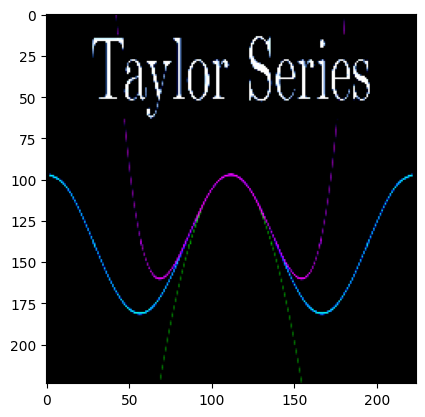

In [141]:
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torch
import clip
from torch.utils.data import Dataset,DataLoader
import os

class YoutubeDataset(Dataset):
    
    def __init__(self,
                batch_size=16,
                valid_size=0.1,
                data_dir = '/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/thumbnails/images/',
                transform = None):
  
        self.transform = transform
        # load the dataset
        train_dataset = datasets.ImageFolder(
            root=data_dir, transform=self.transform,
        )

        num_train = len(train_dataset) # 2303
        
        data = pd.read_csv('/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/Youtube_thumbnails/metadata.csv')
        
        text_list=[]
        id_list = [] 
        
        for i in range(num_train):
            img_id_dir =train_dataset.imgs[i][0].split('.jpg')[0].split('/')[-1]
            # 3d6DsjIBzJ4
            id_list.append(img_id_dir)
            x_text = data[data['Id']==img_id_dir]['Title'].values[0]
            # 그것에 해당하는 타이틀 아이디.
            text_list.append(x_text)

        ch2cat = {}
        for ch in train_dataset.classes: #channels:
            ch2cat[ch] = data[data['Channel']==ch]['Category'].values[0]
            # 3Blue1Brown': 'Science',
            
        id2ch = {}
        for k,v in train_dataset.class_to_idx.items():
            id2ch[v] = k
            # {0: '3Blue1Brown',
        
        id2cat = {}
        for ch,v in train_dataset.class_to_idx.items():
            id2cat[v] =  data[data['Channel']==ch]['Category'].values[0]
            # {0: 'Science',

        id2cat_id = {}
        for ch,v in train_dataset.class_to_idx.items():
            id2cat_id[v] =  label_dict[data[data['Channel']==ch]['Category'].values[0]]             
            # {0: '0',
        self.id_list = id_list
        self.text_samples = text_list
        self.tokenizer = clip.tokenize
        self.num_train = num_train
        self.train_dataset = train_dataset
        self.ch2cat = ch2cat
        self.id2ch = id2ch
        self.id2cat = id2cat
        self.id2cat_id = id2cat_id
        
    def __len__(self):
        # return len(self.text_samples)
        return self.num_train

    def __getitem__(self, i):
        image =self.train_dataset[i][0]
        text = self.tokenizer(self.text_samples[i])
        data_id = self.id_list[i] # id 번호
        channel_id = self.train_dataset[i][1] # 채널 번호 index 
        channel_text = self.id2ch[channel_id] # 채널 이름
        category_id = self.id2cat_id[channel_id]
        category_text = self.id2cat[channel_id]    # 채널 카테고리
        
        return image,text,channel_id ,category_id,data_id

    
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)

# define transforms


train_transform = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    normalize])

dataset = YoutubeDataset(transform=train_transform)#text_list)

data = pd.read_csv('/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/Youtube_thumbnails/metadata.csv')
for i in dataset:
    print(i[0].shape)
    print(i[1].shape)
    print(i[2])
    print(i[3])
    print(i[4])    
    x = i[0].permute(1,2,0).cpu().numpy()
    plt.imshow(x)
    break


In [143]:
data[data['Id']==i[4]]

,Id,Channel,Category,Title
28,3d6DsjIBzJ4,3Blue1Brown,Science,"Taylor series | Chapter 11, Essence of calculus"


# dataloader

In [144]:
from sklearn.model_selection import train_test_split

# Split the train dataset into train and validation sets
train_dataset, valid_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

len(train_dataset),len(valid_dataset)

(1842, 461)

In [145]:
for i in train_dataset:
    print(i[0].shape)
    print(i[1].shape)
    print(i[2])
    print(i[3])
    print(i[4])
    break

torch.Size([3, 224, 224])
torch.Size([1, 77])
69
1
F2xv4fba65U


In [146]:

# Split the train dataset into train and validation sets


# based on https://gist.github.com/srikarplus/8bdb5bedf0ca25e894e39ea78fce2f39
def get_train_valid_loader(train_dataset, valid_dataset, 
                           batch_size,
                           random_seed=2130,
                           shuffle=True,
                           num_workers=4,
                           pin_memory=True):
    """
    
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """

    
    if shuffle:
      np.random.seed(random_seed) 
    
    train_dataset, valid_dataset       

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=0, collate_fn=None, pin_memory=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True,num_workers=0, collate_fn=None, pin_memory=True)



    # return (img_train_loader, img_valid_loader, train_dataset.class_to_idx)
    return (train_dataloader, valid_dataloader)

if __name__=='__main__':
    batch_size = 16
    train_loader,valid_loader = get_train_valid_loader(train_dataset, valid_dataset,  batch_size)
    # print(train_loader)


In [147]:
batch_size = 16
train_loader,valid_loader = get_train_valid_loader(train_dataset, valid_dataset,  batch_size)
for img,txt,ch,cat,id in train_loader:
    print(img.shape)
    print(txt.shape)
    print(ch)
    print(cat)
    print(id)
    break

for img,txt,ch,cat,id in valid_loader:
    print(img.shape)
    print(txt.shape)
    print(ch)
    print(cat)
    print(id)
    break

torch.Size([16, 3, 224, 224])
torch.Size([16, 1, 77])
tensor([35, 62, 40, 86, 35, 68, 34, 33, 26, 83, 37, 42, 52, 89, 19,  7])
tensor([ 5, 11,  0,  8,  5,  4, 14,  1,  4,  5, 15, 11,  2, 13,  0,  2])
('9x2NaGkl6BI', 'g8utYlNlb9A', 'tlTKTTt47WE', 'RurHZGQtbmg', 'yS3k_Inm45Q', 'L8tdPYqFV7E', 'MQEEJ57Gsow', 'Honkq3fKFoA', 'cuHDQhDhvPE', 'TPpoJGYlW54', 'M5v1nXiUaOI', 'fbjYkPKRm-8', 'HpRQx020GDE', '1lJhcmuMeBA', 'cPouwOKMS2s', 'u6TFP_r2oA8')
torch.Size([16, 3, 224, 224])
torch.Size([16, 1, 77])
tensor([68,  9, 75, 26, 30, 88, 80, 23, 45, 74, 57, 75, 32, 14, 15, 18])
tensor([ 4,  7,  8,  4,  4, 11, 10,  0, 17,  6,  0,  8, 13,  8,  9,  8])
('qfS8-Qvvmfk', '3tvegr-O9vI', '1-XqGieWOv8', 'njdJeu95p6s', 'kAEL0zTfbU0', 'OnnxKjvAYLs', 'RKm160Qcnqs', '06w3-l1AzFk', 'yiMlzXMr0KU', '8GxqvnQyaxs', 'NblR01hHK6U', 'k3uW6HTAvRQ', 'SiZ4VkqhGT8', 'sStxk4mv_DY', 'cX1nCBVNRqc', 'A_Aw1auPWe0')


### 조금더 간단한 dataset을 준비했다.
### preprocessed image와 tokenize된 title의 쌍 데이터셋이다.

## dataset 준비
## image, title list 준비

In [159]:
import os
img_dir = '/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/thumbnails/images/'
data = pd.read_csv('/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/Youtube_thumbnails/metadata.csv')
# 이미지 파일 목록 생성
img_list = []
id_list = []
for file in os.listdir(img_dir):
    ch_dir = os.path.join(img_dir,file)
    for images in os.listdir(ch_dir):
        # print(images)
        if images.endswith('.jpg'):
            img_list.append(os.path.join(ch_dir, images))
            img_id = images.split('.jpg')[0]
            id_list.append(img_id)

# 이미지 파일 목록 출력
# print(img_list)
print(id_list) # 2303 

text_list = []
cat_list = []
ch_list = []

for i in id_list:
    text_list.append(data[data["Id"]==i]['Title'].values[0])
    cat_list.append(data[data["Id"]==i]['Category'].values[0])
    ch_list.append(data[data["Id"]==i]['Channel'].values[0])
   
# 아래 다섯가지로 만들 수 있음. 이미지가 부족해서 이미지를 기준으로 만듬. 
# img_list = []
# id_list = []
# text_list = []
# cat_list = []
# ch_list = []


['l0IefQRFVfE', 'pYy5-KowMj0', '015wj1C5wK0', 'VnIsuYVlSls', 'C0f2pu0EVSg', '3kJPxsELVAk', 'MGGhz29kYYA', 'gtXpRZUAc1o', 'qNxQRgsF2NA', 'bdUVehx6UBU', 'WTxTBFU7Sdk', 'pF2mNC4EXfA', 'gKZPPYWTtvc', 'dojhP_1W5tA', 'iokVvwcut5o', '6L-BogO6HwU', 'cvHkteWF5GM', 'y1XbPl1XB44', 'BDd-5qCiL-A', 'AfjrpjqdQxI', 'ZAYZWgGxKO4', '0EhcAzhauRM', '5HInaJxFxWs', 'I6w5AN_Wcak', 'oMA7o8olHzY', 'Gy4QHTgikbk', '3xH1vBuDbBA', 'yiMlzXMr0KU', 'RoVnb_TlJ8A', 'A0Lf8eP41vs', 'tj1D9KAYV1E', 'ipRvjS7q1DI', 'RYSvCb14JjU', 'u3Mqvex6tIE', 'dLyt7H7gyhI', 'kEIvicUmegs', 'UNbgIxL3PyM', '52GCI7rqV4A', 'KoihlAl7ugQ', 'Lwq2WfpY-ss', 'YLWjn0TFH3U', 'mTztlpAcips', '1GfuKF4uENc', 'N5SrDhe4bE0', 'X2jakwIVLbY', '_bggaA5AURA', 'NGbFtTYQpus', 'z2qNEOnlxjA', 'uyU-lKE0Go8', 'oAADFdfa-G4', 'Jl0IDXkYKbk', 'P09pTe54uKM', 'AQWeO5wMekQ', 'RyLXLFaspj0', 'mqZS-hEPE6k', '39ii9LvnDoE', '0xPwHR8_D2w', 'REhLHpdLCE0', 'PDkC1eebWbU', 'qpipLfMiaYU', 'Ev3__YJJH3M', 'YNaBoKLX52M', 'JzWtoP1Xhc0', '5pAnk9MKHzo', 'IbgPYS3RnTA', 'Z4BKrSazQh0', 'FWYsvw_U

# Dataset

In [160]:
import json
from PIL import Image
import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import clip
from transformers import CLIPProcessor, CLIPModel

# with open(json_path, 'r') as f:
#     input_data = []
#     for line in f:
#         obj = json.loads(line)
#         input_data.append(obj)

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, preprocess = clip.load("ViT-B/32", device=device)

class image_title_dataset(Dataset):
    def __init__(self, list_image_path,list_txt):
        # Initialize image paths and corresponding texts
        self.image_path = list_image_path
        # Tokenize text using CLIP's tokenizera
        self.title  = clip.tokenize(list_txt)

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):
        # Preprocess image using CLIP's preprocessing function
        image = preprocess(Image.open(self.image_path[idx]))
        title = self.title[idx]
        return image, title
    

youtube_dataset = image_title_dataset(img_list,text_list)




## train, valid split

이걸 sampler로 만들어서 나누는 동중에 문제가 생겨서 dataset에서 나눠주기로했다.

In [161]:
from sklearn.model_selection import train_test_split

# Split the train dataset into train and validation sets
train_dataset, valid_dataset = train_test_split(youtube_dataset, test_size=0.2, random_state=42)

len(train_dataset),len(valid_dataset)

(1842, 461)

## DataLoader

In [162]:
batch_size = 16
shuffle = True
random_seed = 2130

if shuffle:
    np.random.seed(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=0, collate_fn=None, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True,num_workers=0, collate_fn=None, pin_memory=True)

for img,labels in train_dataloader:
    print(img.shape)
    print(labels.shape)
    break

for img,labels in valid_dataloader:
    print(img.shape)
    print(labels.shape)
    break

torch.Size([16, 3, 224, 224])
torch.Size([16, 77])
torch.Size([16, 3, 224, 224])
torch.Size([16, 77])


### 아래와 같이 sampler를 이용해서 dataloader 단에서 나눠주는것은 실패했다.

In [148]:
#이방법은 실패
# len(train_idx),len(valid_idx)
# train_loader = torch.utils.data.DataLoader(
#     train_dataset,  
#     sampler=train_sampler,
#     num_workers=4,
#     pin_memory =True,
#     drop_last =True,
#     persistent_workers =True
#     )


"""
import numpy as np
num_train = len(train_dataset)          # 50,000
indices = list( range(num_train) )  # 0부터 50,000까지의 숫자가 순서대로 나열된 리스트
np.random.shuffle(indices)          # 0부터 50,000까지의 숫자가 순서없이 뒤섞인 리스트가 됨
split = int( np.floor( 0.2 * num_train ))  # 10,000
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(
    train_dataset,  
    sampler=train_sampler,
    num_workers=4,
    pin_memory =True,
    drop_last =True,
    persistent_workers =True
    )

valid_loader = torch.utils.data.DataLoader(
    train_dataset,  
    sampler=valid_sampler,
    num_workers=2,
    pin_memory =True,
    drop_last =True,
    persistent_workers =True
    )

for img,txt in train_loader:
    print(img.shape)
    print(txt.shape)

"""

# 모델


In [163]:
import json
from PIL import Image
import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import clip
from transformers import CLIPProcessor, CLIPModel

# with open(json_path, 'r') as f:
#     input_data = []
#     for line in f:
#         obj = json.loads(line)
#         input_data.append(obj)

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

class image_title_dataset():
    def __init__(self, list_image_path,list_txt):

            
            
        # Initialize image paths and corresponding texts
        self.image_path = list_image_path
        # Tokenize text using CLIP's tokenizer
        self.title  = clip.tokenize(list_txt)

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):
        # Preprocess image using CLIP's preprocessing function
        image = preprocess(Image.open(self.image_path[idx]))
        title = self.title[idx]
        return image, title
    

# train_dataloader


In [164]:
for img,labels in train_dataloader:
    print(img.shape)
    print(labels.shape)
    break

torch.Size([16, 3, 224, 224])
torch.Size([16, 77])


In [185]:
import torch.optim as optim
import tqdm 

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
print('out device :',device)


def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 


if device == 'cpu':
    model.float()
else :
    clip.model.convert_weights(model) # Actually this line is unnecessary since clip by default already on float16

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2) #Params used from paper, the lr is smaller, more safe for fine tuning to new dataset

EPOCH = 15
# add your own code to track the training progress.
for epoch in range(EPOCH):
    print("Epoch : ",epoch)
    for i,batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        images,texts = batch 

        images= images.to(device)
        texts = texts.to(device)
        
        logits_per_image, logits_per_text = model(images, texts)
        # tensor.size(batch_size, batch_size)
        
        ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
        # tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  ....
        
        total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
        total_loss.backward()
        print('i batch : ',i,'  !!loss :',total_loss)
        if device == 'cpu':
            optimizer.step()
        else : 
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

out device : cpu
Epoch :  0
i batch :  0   !!loss : tensor(0.1969, grad_fn=<DivBackward0>)
i batch :  1   !!loss : tensor(0.2307, grad_fn=<DivBackward0>)
i batch :  2   !!loss : tensor(0.6662, grad_fn=<DivBackward0>)
i batch :  3   !!loss : tensor(0.0368, grad_fn=<DivBackward0>)
i batch :  4   !!loss : tensor(0.5990, grad_fn=<DivBackward0>)
i batch :  5   !!loss : tensor(1.1483, grad_fn=<DivBackward0>)
i batch :  6   !!loss : tensor(0.4925, grad_fn=<DivBackward0>)
i batch :  7   !!loss : tensor(1.0365, grad_fn=<DivBackward0>)
i batch :  8   !!loss : tensor(0.6151, grad_fn=<DivBackward0>)
i batch :  9   !!loss : tensor(1.3992, grad_fn=<DivBackward0>)
i batch :  10   !!loss : tensor(0.7352, grad_fn=<DivBackward0>)
i batch :  11   !!loss : tensor(1.6047, grad_fn=<DivBackward0>)
i batch :  12   !!loss : tensor(1.2360, grad_fn=<DivBackward0>)
i batch :  13   !!loss : tensor(0.9194, grad_fn=<DivBackward0>)
i batch :  14   !!loss : tensor(0.8263, grad_fn=<DivBackward0>)
i batch :  15   !!loss

In [186]:
torch.save(model,'test.pt')

In [187]:
print('saved file')

saved file


In [189]:
torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss,
        }, f"model_{EPOCH}.pt") #just change to your preferred folder/filename

In [192]:
model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training

model, preprocess = clip.load("ViT-B/32", device=device)
checkpoint = torch.load("model_10.pt")

# Use these 3 lines if you use default model setting(not training setting) of the clip. For example, if you set context_length to 100 since your string is very long during training, then assign 100 to checkpoint['model_state_dict']["context_length"] 
# checkpoint['model_state_dict']["input_resolution"] = model.input_resolution #default is 224
# checkpoint['model_state_dict']["context_length"] = model.context_length # default is 77
# checkpoint['model_state_dict']["vocab_size"] = model.vocab_size 

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [194]:
model.parameters()

<generator object Module.parameters at 0x7fe5bd629d60>

# loss function modify

## cross entropy -> contrastive learning



In [213]:
import torch.optim as optim
import tqdm 

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
print('out device :',device)


def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 


if device == 'cpu':
    model.float()
else :
    clip.model.convert_weights(model) # Actually this line is unnecessary since clip by default already on float16

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2) #Params used from paper, the lr is smaller, more safe for fine tuning to new dataset

EPOCH = 15
# add your own code to track the training progress.
# for epoch in range(EPOCH):
    # print("Epoch : ",epoch)
for i,batch in enumerate(train_dataloader):
    print(i)
    optimizer.zero_grad()

    images,texts = batch 
    print(images.shape,texts.shape)
    images= images.to(device)
    texts = texts.to(device)

    logits_per_image, logits_per_text = model(images, texts)
    # tensor.size(batch_size, batch_size) bvgty56 
    # ./,...........''.,5
    
    ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
    # tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  ....
    
    total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
    total_loss.backward()
    print('i batch : ',i,'  !!loss :',total_loss)
    if device == 'cpu':
        optimizer.step()
    break

out device : cpu
0
torch.Size([16, 3, 224, 224]) torch.Size([16, 77])
i batch :  0   !!loss : tensor(0.1016, grad_fn=<DivBackward0>)


In [217]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)

tensor([0, 3, 0])

In [212]:
counts = 0
for i in range(16):
    for j in range(16):
        if logits_per_image[i][j]==logits_per_text.T[i][j]:
            counts+=1
        
            # print(i,j)

print(counts)
        


256
